# 1. Introdução

A Amazon Web Services (AWS) é a plataforma de nuvem mais adotada e mais abrangente do mundo, oferecendo mais de 200 serviços completos de datacenters em todo o mundo. Milhões de clientes, incluindo as startups de crescimento mais rápido, grandes empresas e os maiores órgãos governamentais, estão usando a AWS para reduzirem seus custos, ficarem mais ágeis e inovarem mais rapidamente.

O ambiente AWS permite o processamento e análise de dados direto na nuvem, que implica principalmente em uma redução significativa de tempo de processamento e reduação de espaço fisícos para armazenamento de dados.

Este script tem como objetivo uma análise preditiva com séries temporais em relação a um dataset de aluguel de bikes.

# 2. Carga dos Dados e Análise Exploratória

## 2.1 - Carga de Pacotes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
import numpy as np
import datetime
import boto3
import sagemaker

In [2]:
# Carga da base de dados
base = pd.read_csv('train.csv')
base

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


# 3. Processamento dos dados

In [3]:
# Substitui index pela data
base = pd.read_csv('train.csv', parse_dates=['datetime'], index_col=0)
base

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [6]:
# Drop das colunas, mantém apenas data e valor
base.drop(columns = ['season', 'holiday','workingday','weather','temp','atemp', 'humidity','windspeed','casual', 'registered'], axis=1, inplace = True)
base

,count
datetime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1
...,...
2012-12-19 19:00:00,336
2012-12-19 20:00:00,241
2012-12-19 21:00:00,168


In [7]:
# Agroupamento por dia
base = base.groupby(pd.Grouper(freq = 'D')).sum()
base

,count
datetime,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-12-15,5047
2012-12-16,3786
2012-12-17,4585


In [9]:
# Divisão de treino e teste
base_teste = base.copy()
base_treinamento = base.iloc[0:689,:]

# Visualiza o shape dos dados
print(base_teste.shape)
print(base_treinamento.shape)

(719, 1)
(689, 1)


In [14]:
# Primeira e última data na base de treino
base_treinamento.index.min(), base_treinamento.index.max()

(Timestamp('2011-01-01 00:00:00', freq='D'),
 Timestamp('2012-11-19 00:00:00', freq='D'))

In [15]:
# Primeira e última data na base de teste
base_teste.index.min(), base_teste.index.max()

(Timestamp('2011-01-01 00:00:00', freq='D'),
 Timestamp('2012-12-19 00:00:00', freq='D'))

In [21]:
# Separa os períodos em treino e teste no formato datetime
dt_data_inicial = pd.Timestamp("2011-01-01", freq = 'D')
dt_data_final_treinamento = pd.Timestamp("2012-11-19", freq = 'D')
dt_previsao_maxima = pd.Timestamp("2012-12-19", freq = 'D')

faixa_treinamento = (dt_data_inicial, dt_data_final_treinamento)
faixa_teste = (dt_data_inicial, dt_previsao_maxima)

/tmp/ipykernel_201/3675250973.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_data_inicial = pd.Timestamp("2011-01-01", freq = 'D')
/tmp/ipykernel_201/3675250973.py:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_data_final_treinamento = pd.Timestamp("2012-11-19", freq = 'D')
/tmp/ipykernel_201/3675250973.py:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_previsao_maxima = pd.Timestamp("2012-12-19", freq = 'D')


In [22]:
# Período do treino
faixa_treinamento

(Timestamp('2011-01-01 00:00:00', freq='D'),
 Timestamp('2012-11-19 00:00:00', freq='D'))

In [23]:
# Período do teste
faixa_teste

(Timestamp('2011-01-01 00:00:00', freq='D'),
 Timestamp('2012-12-19 00:00:00', freq='D'))

In [24]:
# Série de treino e teste para o modelo

# Cria objeto do tipo lista
serie_temporal_treinamento = []
serie_temporal_teste = []

# Inclui dados do tipo datetime em treino e teste
serie_temporal_treinamento.append(base_treinamento[faixa_treinamento[0]:faixa_treinamento[1]]['count'])
serie_temporal_teste.append(base_teste[faixa_teste[0]:faixa_teste[1]]['count'])

In [25]:
# Verifica tipo dos dados
type(serie_temporal_treinamento), type(serie_temporal_teste)

(list, list)

In [27]:
# Visualiza treino
serie_temporal_treinamento

[datetime
 2011-01-01     985
 2011-01-02     801
 2011-01-03    1349
 2011-01-04    1562
 2011-01-05    1600
               ... 
 2012-11-15    5445
 2012-11-16    5698
 2012-11-17    5629
 2012-11-18    4669
 2012-11-19    5499
 Freq: D, Name: count, Length: 689, dtype: int64]

In [28]:
# Visualiza teste
serie_temporal_teste

[datetime
 2011-01-01     985
 2011-01-02     801
 2011-01-03    1349
 2011-01-04    1562
 2011-01-05    1600
               ... 
 2012-12-15    5047
 2012-12-16    3786
 2012-12-17    4585
 2012-12-18    5557
 2012-12-19    5267
 Freq: D, Name: count, Length: 719, dtype: int64]

In [29]:
# tamanho do treino e teste
len(serie_temporal_treinamento[0]), len(serie_temporal_teste[0])

(689, 719)

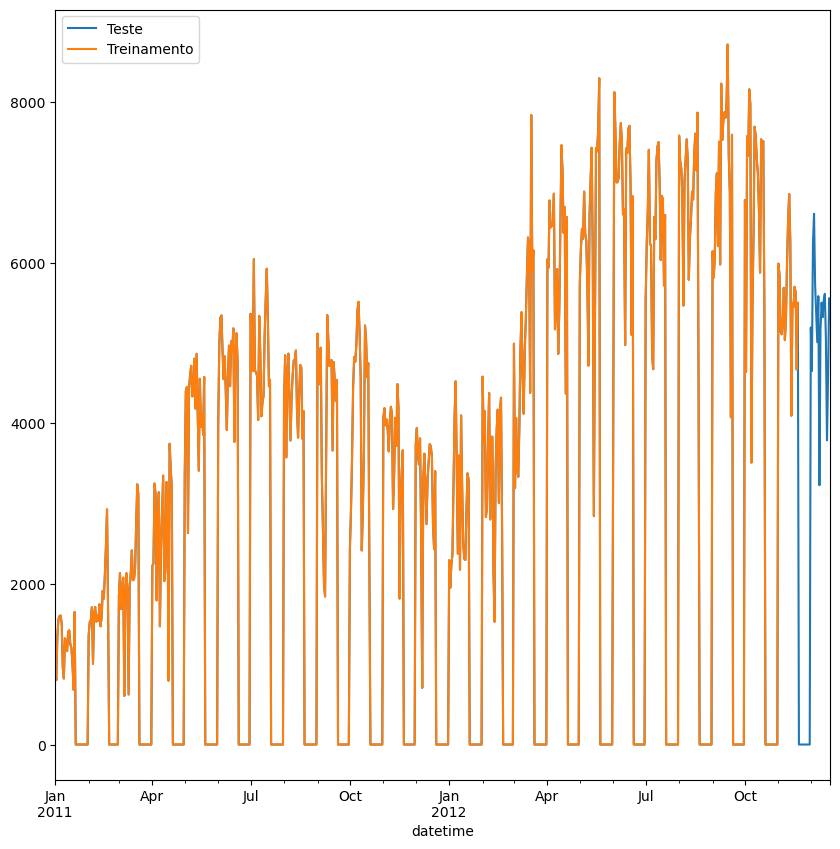

In [30]:
# plot dos dados
plt.figure(figsize=(10,10))
serie_temporal_teste[0].plot(label = "Teste")
serie_temporal_treinamento[0].plot(label = "Treinamento")
plt.legend()
plt.show()

## 3.1 Preparação dos dados para enviar ao SageMaker

In [31]:
# Função para retornar a quantidades de bikes alugadas
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

In [33]:
# Visualiza um exemplo de aplicação da função
encode_target(serie_temporal_treinamento[0][0:25])

[985,
 801,
 1349,
 1562,
 1600,
 1606,
 1510,
 959,
 822,
 1321,
 1263,
 1162,
 1406,
 1421,
 1248,
 1204,
 1000,
 683,
 1650,
 0,
 0,
 0,
 0,
 0,
 0]

In [34]:
# Funação para converter time series em tipo objeto dicionário
def series_to_obj(ts):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    return obj

In [36]:
# Visualiza os dados como exemplo aplicando a função
series_to_obj(serie_temporal_treinamento[0][0:5])

{'start': '2011-01-01 00:00:00', 'target': [985, 801, 1349, 1562, 1600]}

In [37]:
# Função que comverte os dados em tipo json
def series_to_jsonline(ts):
    return json.dumps(series_to_obj(ts))

In [39]:
# Visualiza os dados como exemplo aplicando a função
series_to_jsonline(serie_temporal_treinamento[0][0:5])

'{"start": "2011-01-01 00:00:00", "target": [985, 801, 1349, 1562, 1600]}'

In [40]:
# Configura os parâmetros para criar um arquivo json com os dados de treino e teste

encoding = 'utf-8' #condificação do arquivo
arquivo_json_treinamento = 'train.json' #arquivo de treino
arquivo_json_teste = 'test.json' #arquivo de teste

#Função que cria o arquivo de treinamento
with open(arquivo_json_treinamento, 'wb') as fp:
    for ts in serie_temporal_treinamento:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# Função que cria o arquivo de teste
with open(arquivo_json_teste, 'wb') as fp:
    for ts in serie_temporal_teste:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# 4. Configuração do SageMaker

Capítulo onde é feita toda a configuração do SageMaker no ambiente AWS. Toda a configuração foi comentada devido problemas para rodar o AWS devido as cobranças com cartão de crédito.

In [ ]:
# Cria sessões e bem como caminhos de pasta para armazenamento dos datasets do modelo

session = sagemaker.Session() #Sessão do SageMaker
role = sagemaker.get_execution_role() # Identifica as permissões do SageMaker que foi feita quando criado o usuário
job_name = 'deepar-bike' # nome para o treino do modelo
bucket = 'cursoawssagemaker' # Envia o dataset binário para o bucket do S3
subpasta_dataset = 'datasets/bike' # Pasta para armazenar a base de dados
subpasta_modelo = 'modelos/bike/deepar' # Pasta para armazenar o modelo do SageMaker
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, subpasta_dataset, 'train.json') # Pasta para a base de trainamento do modelo
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, subpasta_dataset, 'test.json') # Pasta para a base de teste do modelo
output_location = 's3://{}/{}/output'.format(bucket, subpasta_modelo) # Pasta para a base de trainamento do modelo

# Visualização das variáveis
print('Role: {}'.format(role))
print('Localização da base de treinamento: {}'.format(s3_train_data))
print('Localização da base de teste: {}'.format(s3_test_data))
print('Modelo será salvo em: {}'.format(output_location))

In [ ]:
# Função para Upload dos dados para o S3
def escreve_s3(arquivo, bucket, nome):
    with open(arquivo, 'rb') as f:
        return boto3.Session().resource('s3').Bucket(bucket).Object(nome).upload_fileobj(f)

In [ ]:
# Upload dos dados para o S3
escreve_s3('train.json', bucket, os.path.join(subpasta_dataset, 'train', 'train.json'))
escreve_s3('test.json', bucket, os.path.join(subpasta_dataset, 'test', 'test.json'))

In [ ]:
# Visualiza o caminho das pastas
print(os.path.join(subpasta_dataset, 'train', 'train.json'))
print(os.path.join(subpasta_dataset, 'test', 'test.json'))

# 5. Treinamento do DeepAR

In [ ]:
# Criar container do AWS que importa o DeepAr
container = sagemaker.image_uris.retrieve(framework = 'forecasting-deepar', region = session.boto_region_name)

In [ ]:
# Cria modelo do DeepAR
deepar = sagemaker.estimator.Estimator(image_uri = container, # Acesso ao algoritmo
                                       role = role, # Permissões SageMaker
                                       instance_count = 1, # Número de instância do SageMaker
                                       instance_type = 'ml.m5.large',  # Instância do SageMaker
                                       output_path = output_location, # Saíde do modelo
                                       sagemaker_session = session, # Sessão do SageMaker
                                       base_job_name = job_name, # nome para o treino do modelo
                                       use_spot_instances = True, # Reduz os custos de treinamento
                                       max_run = 3600, # Tempo em segundos de espera para o treino
                                       max_wait = 3600) # Tempo em segundos para que uma instância ociosa seja encontrada

In [ ]:
# Ajuste dos hiperparâmetros
freq = 'D'
prediction_length = 30
context_length = 30

In [ ]:
# Dicionário com os hiperparâmetros
hyperparametros = {
    'time_freq': freq,
    'epochs': "20",
    'context_length': str(context_length),
    'prediction_length': str(prediction_length)
}

In [ ]:
# Aplica os hiperparâmetros
deepar.set_hyperparameters(**hyperparametros)

In [ ]:
# Cria nova variável que une treino e teste
data_channels = {'train': s3_train_data, 'test': s3_test_data}
data_channels

In [ ]:
# Fit do modelo
deepar.fit(inputs = data_channels)

# 6. Deploy e previsões

In [ ]:
# Print do último training job utilizado pelo SageMaker
job_name = deepar.latest_training_job.name
print('Job name: ', job_name)

In [ ]:
# Cria o endpoint
endpoint = session.endpoint_from_job(job_name = job_name,
                                     initial_instance_count = 1,
                                     instance_type = "ml.m5.large",
                                     image_uri = container,
                                     role = role)

In [ ]:
# Visualiza o endpoint
print('Endpoint: ', endpoint)

In [ ]:
# Funções para previsões do modelo
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. 
          This method **must** be called before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, 
           each with the (optional) corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k]) for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [ ]:
predictor = DeepARPredictor(endpoint_name = 'deepar-bike-2022-05-19-19-15-14-057',
                            sagemaker_session = session)
predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = "application/json"

In [ ]:
previsoes = predictor.predict(serie_temporal_treinamento)

In [ ]:
len(previsoes[0])

In [ ]:
previsoes

In [ ]:
for k in range(len(previsoes)):
    plt.figure(figsize=(12,6))
    previsoes[k]['0.5'].plot(label = 'Mediana', color = 'red')
    #serie_temporal_teste[k].plot(label = 'Alvo')
    serie_temporal_teste[k][-prediction_length - context_length:].plot(label = 'Alvo')
    p10 = previsoes[k]['0.1']
    p90 = previsoes[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color = 'y', alpha = 0.5, label = 'Intervalo de confiança')
    plt.legend()
    plt.show()

In [ ]:
df_teste = base.iloc[689:,:]
len(df_teste)

In [ ]:
df_teste

In [ ]:
previsoes2 = previsoes[0]['0.5'].values
previsoes2

In [ ]:
esperado = df_teste['count'].values
esperado

In [ ]:
# Avaliação do modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(esperado, previsoes2)
mse = mean_squared_error(esperado, previsoes2)
print('MAE: ', mae, '\nMSE: ', mse)

# 7. Links Úteis

###### Baseado em: https://github.com/ChandraLingam/AmazonSageMakerCourse/tree/master/DeepAR/BikeRental
###### https://www.kaggle.com/competitions/bike-sharing-demand/data
###### https://docs.aws.amazon.com/sagemaker/latest/dg/ecr-sa-east-1.html
###### https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html
###### https://github.com/aws-samples/amazon-sagemaker-managed-spot-training/blob/main/xgboost_built_in_managed_spot_training_checkpointing/xgboost_built_in_managed_spot_training_checkpointing.ipynb
###### https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html